In [1]:
import sys
import xarray as xr
import numpy as np
import Plotter
from Plotter import Plotter
import time
from preprocessing_utils_sampling import *
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split, ShuffleSplit
from sklearn import metrics
import pyxpcm
from pyxpcm.models import pcm
import warnings
import glob
import seaborn as sns
from joblib import dump, load

from joblib import Parallel, delayed
import multiprocessing

warnings.filterwarnings('ignore')

In [2]:
%load_ext memory_profiler
%load_ext line_profiler

In [3]:
def score_model(m, m_full, x):
    pred = m.predict(x)
    truth = m_full.predict(x)
    print("sample")
    print(f"model score (higher is best): {m.score(x)}")
#     print(f"silhouette score (closer to 1 is best): {metrics.silhouette_score(x, pred)}")
    print("---------------------------------------------------")
    print("full")
    print(f"model score (higher is best): {m_full.score(x)}")
#     print(f"silhouette score (closer to 1 is best): {metrics.silhouette_score(x, truth)}")
    print("---------------------------------------------------")
    print(f" adjusted rand score: {metrics.adjusted_rand_score(truth, pred)}")
    print(f" unadjusted rand score: {metrics.rand_score(truth, pred)}")
    print("---------------------------------------------------")
    print(f" adjusted mutual info score: {metrics.adjusted_mutual_info_score(truth, pred)}")
    print(f" unadjusted mutual info score: {metrics.mutual_info_score(truth, pred)}")

#     print(f"model score: {m.score(x)}")
#     print(f"model score: {m.score(x)}")

In [4]:
def score_iter(m, m_full, x):
    pred = m.predict(x)
    truth = m_full.predict(x)
    return m.score(x), metrics.rand_score(truth, pred), metrics.mutual_info_score(truth, pred)

In [5]:
def predict(x, m, var_name_ds, k, var_predict):
    classif = m.predict(x[var_predict])
    x = x.assign(variables={"labels": ('sample_dim', classif)})
    q = [0.05, 0.5, 0.95]
    x = compute_quantile(x, var_name_ds, k, q)
    x = x.assign_coords(coords={'k': range(k)})
    x = x.unstack('sample_dim')
    return x

In [6]:
def generate_plots(ds, var_name_ds, k, algorithm):
    """
    Generates and saves the following plots:
    - vertical structure: vertical structure of each classes. It draws the mean profile and the 0.05 and 0.95 quantiles
    - vertical structure comp: vertical structure graph but Quantiles are being plotted together to highlight
    differences between classes.
    - Spacial distribution: plot the PCM labels in a map to analyse the spatial coherence of classes.
    - Robustness: spacial distribution of a scaled probability of a profile to belong to a class.
    - Pie chart: pie chart showing the percentage of profiles belonging to each class and the number of
    classified profiles.
    - Temporal distribution by month: The bar plots represents the percentage of profiles in each class by month.
    - Temporal distribution by season: The bar plots represents the percentage of profiles in each class by season.
    Parameters
    ----------
    ds : Xarray dataset containing the predictions
    var_name_ds : name of the variable in the dataset

    Returns
    -------
    saves all the plots as png
    """
    try:
        x_label = ds[var_name_ds].attrs['long_name'] + " in " + ds[var_name_ds].attrs['unit_long']
    except KeyError:
        x_label = var_name_ds

    # create a pyXpcm model to use the Plotter class
    var_name_mdl = var_name_ds
    z_dim = 'depth'
    z = ds[z_dim]
    pcm_features = {var_name_mdl: z}
    m = pcm(K=k, features=pcm_features)
    ds = ds.rename({'labels': 'PCM_LABELS'})
    ds = ds.sortby('latitude').sortby('longitude')
    P = Plotter(ds, m, coords_dict={'latitude': 'latitude', 'longitude': 'longitude', 'time': 'time', 'depth': 'depth'})

    # plot profiles by class
    P.vertical_structure(q_variable=var_name_ds + '_Q', sharey=True, xlabel=x_label)
#     P.save_BlueCloud(f'./GMM_scaling_out/vertical_struc{algorithm}.png')
    # plot profiles by quantile
    P.vertical_structure_comp(q_variable=var_name_ds + '_Q', plot_q='all', xlabel=x_label)
#     P.save_BlueCloud(f'./GMM_scaling_out/vertical_struc_comp{algorithm}.png')
    # spacial distribution
    P.spatial_distribution(time_slice='most_freq_label')
#     P.save_BlueCloud(f'./GMM_scaling_out/spatial_distr_freq{algorithm}.png')
    # robustness
    # P.plot_robustness(time_slice=first_date)
    # P.save_BlueCloud('robustness.png')
    # pie chart of the classes distribution
    P.pie_classes()
#     P.save_BlueCloud(f'./GMM_scaling_out/pie_chart{algorithm}.png')
    # temporal distribution (monthly)
    try:
        P.temporal_distribution(time_bins='month')
#         P.save_BlueCloud('temporal_distr_months.png')
    except (ValueError, AssertionError) as e:
#         save_empty_plot('temporal_distr_months')
        print('plot monthly temporal distribution is not available, the following error occurred:')
        print(e, file=sys.stderr)
    # temporal distribution (seasonally)
    try:
        P.temporal_distribution(time_bins='season')
#         P.save_BlueCloud('temporal_distr_season.png')
    except (ValueError, AssertionError) as e:
#         save_empty_plot('temporal_distr_season')
        print('plot seasonal temporal distribution is not available, the following error occurred:')
        print(e, file=sys.stderr)

# Execution of the code

## parameters

In [7]:
# var_name_ds = "TEMP"
var_name_ds = 'thetao'
var_name_mdl = "temperature"
# algorithm choice can be: "kmean" for classic sklarn kmean, "batch" for sklearn kmean mini-batch, "GMM" for sklearn GMM
algorithm = "GMM"
k = 6
# file_name = '../datasets/global-reanalysis-phy-001-030-monthly_big.nc'
# dir_path = '/home/ref-coriolis-public/copernicus/INSITU_GLO_TS_OA_REP_OBSERVATIONS_013_002_b/CORIOLIS-GLOBAL-CORA-OBS_FULL_TIME_SERIE/field/'
# file_list = glob.glob(f"{dir_path}2019/*TEMP.nc")
# file_list+=glob.glob(f"{dir_path}2018/*TEMP.nc")

dir_path = "../datasets/"
file_list = glob.glob(f"{dir_path}global-reanalysis-phy-001-030-monthly_big.nc")
print(len(file_list))

len(file_list)
# spacial_domain = {"lon":[-5, 42],
#                  "lat": [30, 46],
#                  "depth": 800}
spacial_domain = {"lon":[-80, 80],
                 "lat": [-80, 80],
                 "depth": 800}
spacial_domain

1


{'lon': [-80, 80], 'lat': [-80, 80], 'depth': 800}

## Load and preprocessing
see in file preprocessing utils for details

In [8]:
x = preprocessing_allin(path=file_list, scaling=True, multiple=True, backend='sk', 
                        var_name=var_name_ds, n_comp_pca=15, spacial_domain=spacial_domain)
x

size full DS: 1.303983673453331 Go
size after selection of variable: 1.303983673453331 Go


<xarray.Dataset>
Dimensions:                (depth: 30, feature: 30, feature_reduced: 15, sample_dim: 3466693)
Coordinates:
  * depth                  (depth) float32 -0.494 -1.541 ... -318.1 -380.2
  * sample_dim             (sample_dim) MultiIndex
  - longitude              (sample_dim) float64 -5.0 -5.0 -5.0 ... 41.5 41.5
  - latitude               (sample_dim) float64 35.75 35.75 ... 41.83 41.83
  - time                   (sample_dim) datetime64[ns] 2010-08-16T12:00:00 .....
Dimensions without coordinates: feature, feature_reduced
Data variables:
    thetao                 (sample_dim, depth) float32 25.16 25.02 ... 8.815
    thetao_scaled          (sample_dim, feature) float32 1.066 1.055 ... -2.255
    thetao_scaled_reduced  (sample_dim, feature_reduced) float32 -2.758 ... -...
Attributes: (12/17)
    title:                         Monthly mean fields for product GLOBAL_REA...
    references:                    http://marine.copernicus.eu
    credit:                        E.U. Copernicus Marine Service Information...
    licence:                       http://marine.copernicus.eu/services-portf...
    contact:                       servicedesk.cmems@mercator-ocean.eu
    producer:                      CMEMS - Global Monitoring and Forecasting ...
    ...                            ...
    source:                        MERCATOR GLORYS12V1
    product_user_manual:           http://marine.copernicus.eu/documents/PUM/...
    quality_information_document:  http://marine.copernicus.eu/documents/QUID...
    _CoordSysBuilder:              ucar.nc2.dataset.conv.CF1Convention
    comment:                       
    history:                       Data extracted from dataset http://localho...

## Training

In [9]:
var_train = var_name_ds + "_scaled_reduced"

In [12]:
%%time
# m_full = train_model(k=k, x=x[var_train], algo=algorithm)
m_full = load('modelk6_full_10y.joblib')

CPU times: user 4.93 ms, sys: 307 µs, total: 5.23 ms
Wall time: 4.95 ms


In [13]:
# dump(m_full, 'modelk6_full_10y.joblib') 

In [14]:
m_full.score(x[var_train])

20.165304411520065

## subsampling for training

In [27]:
%%time
score = -np.infty
max_lower_bound = -np.infty
for i in range(10):
    print(f"iter number: {i}")
    index_train = np.random.choice(len(x[var_train]), 20_000)
    m_i = sklearn.mixture.GaussianMixture(n_components=k, max_iter=1000, tol=1e-8, n_init=1)
    m_i.fit(x[var_train][index_train])
    score_i = m_i.score(x[var_train])
    print(f"number iterations: {m_i.n_iter_}")
    print(f"score _i: {score_i}")
    print(f"lower_bound: {m_i.lower_bound_}")
    if score_i>score:
#     if max_lower_bound < m_i.lower_bound_:
        max_lower_bound = m_i.lower_bound_
        score = score_i
        m = m_i
        print("new best model, updating")

m.score(x[var_train])

iter number: 0
number iterations: 165
score _i: 20.12605742952576
lower_bound: 20.185380846998054
new best model, updating
iter number: 1
number iterations: 322
score _i: 20.112876483378773
lower_bound: 20.228406286948694
iter number: 2
number iterations: 255
score _i: 20.10660484813067
lower_bound: 20.38322144739745
iter number: 3
number iterations: 285
score _i: 20.119813880191934
lower_bound: 20.26410969984227
iter number: 4
number iterations: 144
score _i: 20.111060330435272
lower_bound: 20.070462936095208
iter number: 5
number iterations: 239
score _i: 20.118138584072913
lower_bound: 20.277778251535107
iter number: 6
number iterations: 180
score _i: 20.11442067104667
lower_bound: 20.215442042113665
iter number: 7
number iterations: 327
score _i: 20.11809233130064
lower_bound: 20.30112293094786
iter number: 8
number iterations: 170
score _i: 20.118200220994982
lower_bound: 20.282751532312208
iter number: 9
number iterations: 254
score _i: 20.118020498152347
lower_bound: 20.24593586

20.12605742952576

In [28]:
score_model(m=final, m_full=m_full, x=x[var_train])

sample
model score (higher is best): 20.120763525217146
---------------------------------------------------
full
model score (higher is best): 20.165304411520065
---------------------------------------------------
 adjusted rand score: -2.993834658259726
 unadjusted rand score: 0.9816484781955189
---------------------------------------------------
 adjusted mutual info score: 0.9378585157193413
 unadjusted mutual info score: 1.54639847084394


## Prediction and quantile computation

In [29]:
%%time
ds = predict(m=m, x=x, var_name_ds=var_name_ds, var_predict = var_name_ds + "_scaled_reduced", k=k)

CPU times: user 26 s, sys: 7.51 s, total: 33.5 s
Wall time: 8.23 s


## Plots

plot finished in 19.856497049331665sec
exec time saved
CPU times: user 10.4 s, sys: 7.38 s, total: 17.8 s
Wall time: 19.9 s


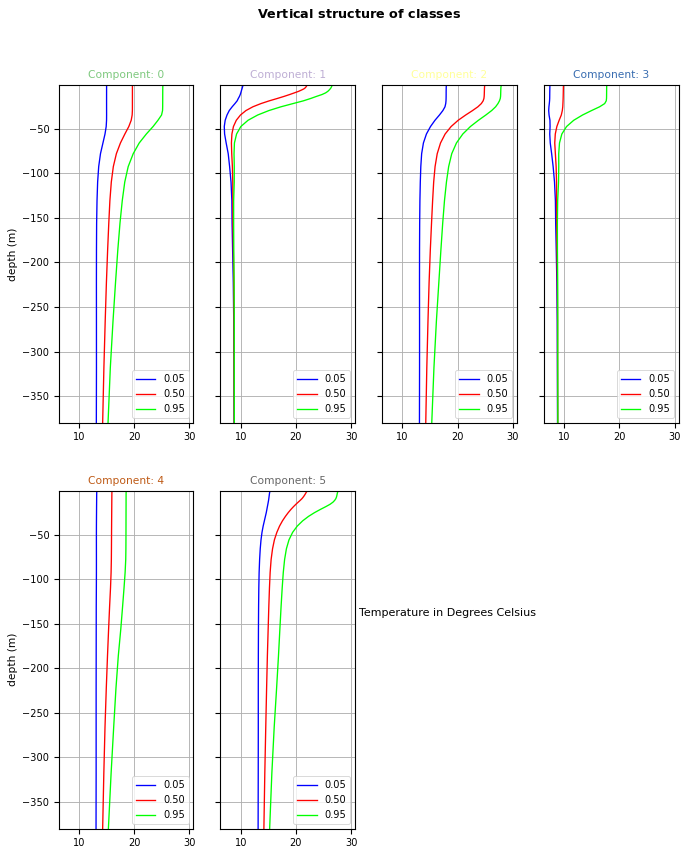

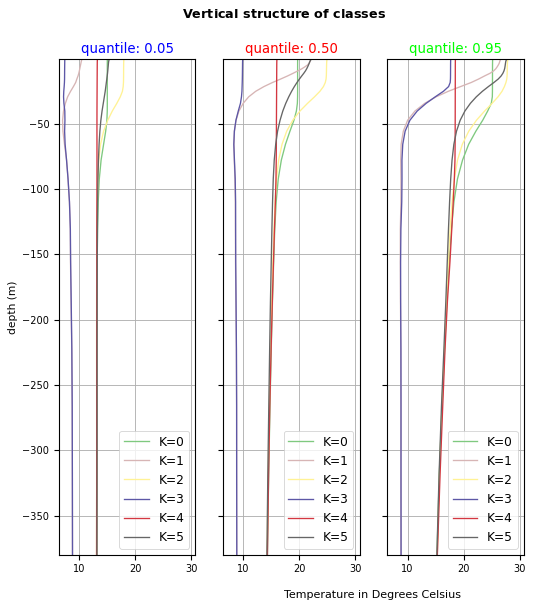

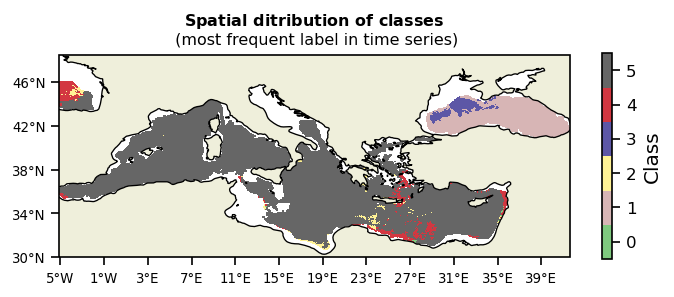

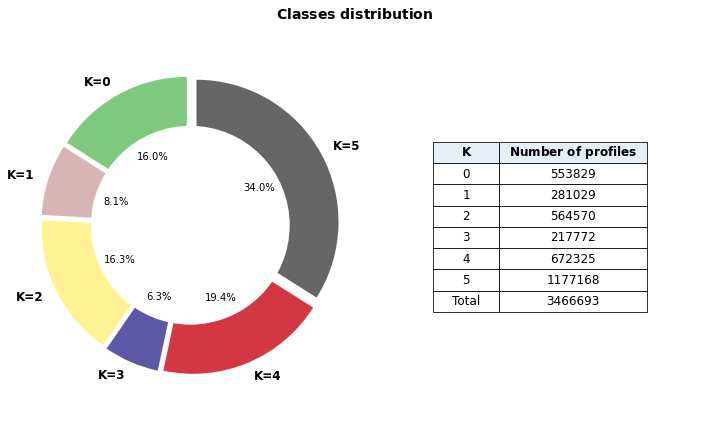

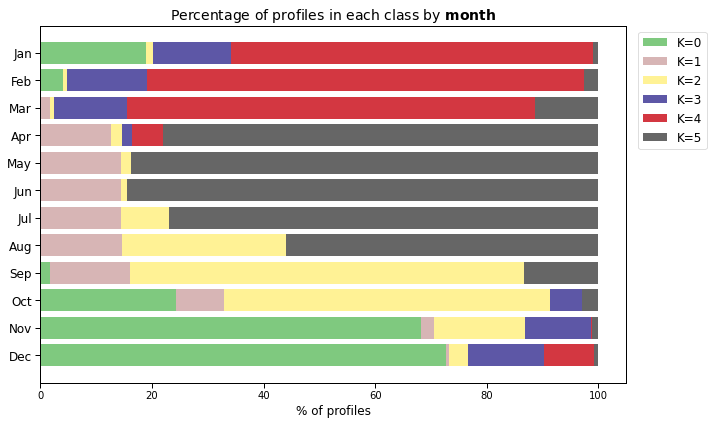

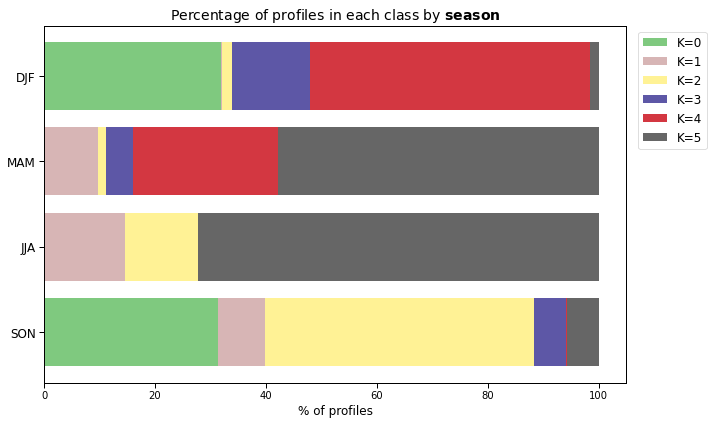

In [30]:
%%time
# name_ext = '_trainsize' + str(train_size)
# name_ext = '_full2'
start_time = time.time()
generate_plots(ds=ds, var_name_ds=var_name_ds, k=k, algorithm=algorithm)
plot_time = time.time() - start_time
print("plot finished in " + str(plot_time) + "sec")